In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

import math

import time

from matplotlib import cm

import matplotlib.lines as mlines

sns.set()
%matplotlib inline

### AIR POLLUTION MONITORING DATA FROM EDF

In [4]:
df = pd.read_csv('EDF_Data.csv', header = 1)
df['TimePeriod'] = 'Jun2015-May2016'
df.tail()

,Longitude,Latitude,NO Value,NO2 Value,BC Value,TimePeriod
21483,-122.034943,37.560076,129.999995,44.778220,3.923761,Jun2015-May2016
21484,-122.034724,37.560164,60.799998,39.027545,1.408693,Jun2015-May2016
21485,-122.034681,37.559830,34.622951,28.816797,2.659885,Jun2015-May2016
21486,-122.034504,37.559958,74.764705,35.735434,1.776353,Jun2015-May2016
21487,-122.034503,37.559957,78.754782,41.062757,2.014664,Jun2015-May2016


### Split dataset into Black Carbon and NO2 measurements

In [5]:
BC_df = df[['Longitude', 'Latitude', 'BC Value', 'TimePeriod']]

In [6]:
NO2_df = df[['Longitude', 'Latitude', 'NO2 Value', 'TimePeriod']]

#### FACILITY LEVEL DATA IN OAKLAND

In [62]:
Facility_PM = pd.read_csv("Data/All_PM_Facilities_Final.csv")

In [63]:
Facility_PM.drop(columns = ['Unnamed: 0'], inplace=True)

In [64]:
Facility_PM.tail()

,eis facility id,company,source-category,latitude,longitude,city,PM25,PM10,units,source-type
343,18776511,Unknown,Manufacturing,37.853018,-122.292710,BERKELEY,0.010500,0.010500,TON,Manufacturing
344,18778911,Unknown,Wholesale,37.712960,-122.188680,SAN-LEANDRO,22.124544,22.971518,TON,Wholesale
345,18779811,Unknown,Manufacturing,37.707820,-122.185500,SAN-LEANDRO,0.000015,0.000015,TON,Manufacturing
346,18782611,Unknown,Waste-Recycling,37.759959,-122.207782,OAKLAND,0.992654,1.030213,TON,Waste-Recycling
347,18787011,Unknown,Manufacturing,37.766939,-122.216336,OAKLAND,0.079014,0.131690,TON,Manufacturing


### <font color='red'>  Basic Statistical Analysis </font>

In [51]:
BC_df.describe()

,Longitude,Latitude,BC Value
count,21488.000000,21488.000000,21488.000000
mean,-122.214966,37.768860,0.726349
std,0.065693,0.052732,0.605508
min,-122.322594,37.559830,-0.516773
25%,-122.276182,37.744525,0.321264
50%,-122.198630,37.773564,0.501429
75%,-122.167735,37.809764,0.985597
max,-122.034503,37.837491,8.154735


#### There are 21,488 measurements taken in the Oakland area and the average concentration of Black Carbon between June 2015 - May 2016 is 0.72 ug/m3. 
#### This is roughly the average state-wide concentrations measured back in 2004 - 2005 indicating that the black carbon concentrations are pretty high in the area. The maximum concentration is as high as 8.1 ug/m3 in some areas, indicating that most of the concentration must be from large industrial processes or diesel fueled vehicles. 
#### The current state-wide black carbon concentration is xxx. The main sources of black carbon are from diesel-fueled vehicles, industrial processes, residential fireplaces and woodstoves. Black Carbon is a component of a type of PM2.5.



In [65]:
NO2_df.describe()

,Longitude,Latitude,NO2 Value
count,21488.000000,21488.000000,21488.000000
mean,-122.214966,37.768860,17.191827
std,0.065693,0.052732,9.698447
min,-122.322594,37.559830,3.284827
25%,-122.276182,37.744525,9.835145
50%,-122.198630,37.773564,14.965925
75%,-122.167735,37.809764,22.423004
max,-122.034503,37.837491,60.463163


#### Similar to black carbon, the average NO2 concentration in the area is 17 ppb, which is lower than the National Ambient Air quality Standards of 53 ppb and California Ambient Air Quality Standards of 30 ppb. However, the maximum concentration in the area is 60 ppb, indicating the NO2 concentrations in some areas exceed standards. This could be due to proximity of measurement areas of traffic or industrial sources.  

In [66]:
Facility_PM.describe()[['latitude','longitude','PM25','PM10']]

,latitude,longitude,PM25,PM10
count,348.000000,348.000000,3.480000e+02,3.480000e+02
mean,37.785381,-122.239371,4.811451e-01,6.368840e-01
std,0.053832,0.052052,2.289948e+00,2.978462e+00
min,37.674500,-122.319375,4.000000e-09,5.000000e-09
25%,37.742283,-122.278356,1.342943e-04,1.438983e-04
50%,37.795385,-122.259050,6.924440e-04,7.594420e-04
75%,37.817870,-122.196720,2.344960e-02,2.608391e-02
max,37.888535,-122.107740,2.212454e+01,2.626146e+01


In [58]:
Facility_PM.groupby('source-type').describe()['PM25'].sort_values('count')

,count,mean,std,min,25%,50%,75%,max
source-type,,,,,,,,
Solvent,1.0,0.041635,NaN,4.163528e-02,0.041635,0.041635,0.041635,0.041635
PipePlant,1.0,6.331136,NaN,6.331136e+00,6.331136,6.331136,6.331136,6.331136
Bakeries,1.0,0.072196,NaN,7.219629e-02,0.072196,0.072196,0.072196,0.072196
Breweries,1.0,0.086911,NaN,8.691087e-02,0.086911,0.086911,0.086911,0.086911
Pharma,1.0,0.320284,NaN,3.202845e-01,0.320284,0.320284,0.320284,0.320284
Parking,1.0,0.000678,NaN,6.780660e-04,0.000678,0.000678,0.000678,0.000678
DataCenter,1.0,0.003173,NaN,3.173066e-03,0.003173,0.003173,0.003173,0.003173
USCG,1.0,0.000142,NaN,1.424210e-04,0.000142,0.000142,0.000142,0.000142
FiberGlass,1.0,0.470400,NaN,4.704000e-01,0.470400,0.470400,0.470400,0.470400


#### There are a total of 362 stationary sources of black carbon (PM2.5) emissions in Oakland. The maximum emissions from these sources is roughly 26 tons of PM10 and 22 tons of PM10 indicating that one of the facility is large. The largest emittors in this area are Asphalt Plants, Concrete/Pipe manufacturing plants, Concrete batch processing plants, and food manufacturing plants like coffee. 

#### Looking at this list of sources, there are 159 sources classified as institutions which includ office buildings, schools, hospitals, lab facilities colleges etc. and 32 manufacturing facilities in the area

### <font color='red'>  Trend Analysis </font>

### <font color='red'>  Bar Plots/Histograms </font>

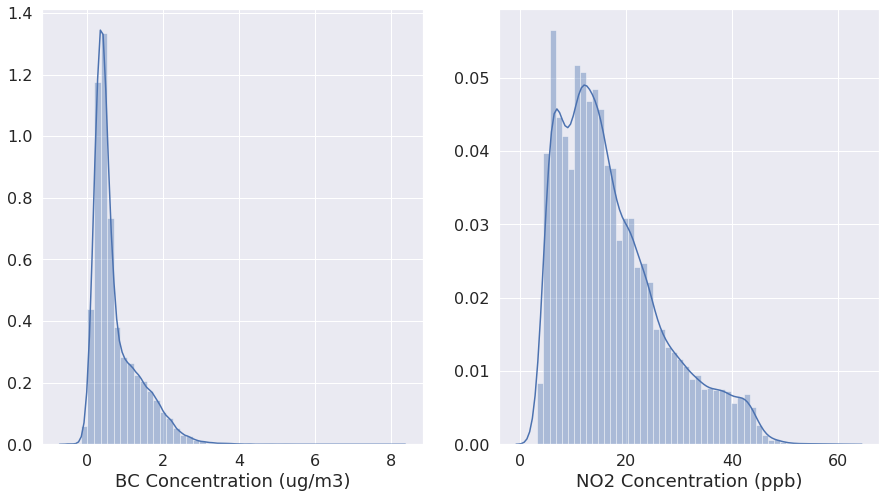

In [75]:
figure, (ax1, ax2) = plt.subplots(1,2, figsize = (15,8))
sns.distplot(BC_df['BC Value'], ax = ax1)
ax1.set_xlabel('BC Concentration (ug/m3)', fontsize = 18)
sns.distplot(NO2_df['NO2 Value'], ax = ax2)
ax2.set_xlabel('NO2 Concentration (ppb)', fontsize = 18)

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)